In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np 
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.optim import lr_scheduler

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [4]:
batch_size = 32

In [5]:
train_transform = transforms.Compose([
        transforms.Resize(256),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [6]:
train_dir = '../input/facial-age/face_age/face_age'
files = os.listdir(train_dir)
#files = files.remove('face_age')
print(len(files))


99


In [7]:
d = '../input/facial-age/face_age/face_age/110'
print(d.split('/')[-1])
for i in files:
    if i in d.split('/')[-1]:
        print(int(i))

110
110


In [8]:
classes = []

for i in os.listdir(train_dir):
    classes.append(i)
classes = sorted(classes)
print(len(classes))

99


In [9]:
class AgeDataset(Dataset):
    def __init__(self,directory,file_list,transform = None):
        self.directory = directory
        self.file_list = file_list
        self.transform = transform
        self.k = k
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img =  Image.open(os.path.join(self.directory, self.file_list[idx]))
        img = img.convert('RGB')
        img = self.transform(img)
        
        for i in classes:
            if i == self.directory.split('/')[-1]:
                self.label = int(i)
                
            else:
                continue
                
        img = img.numpy()
        return img.astype('float32'), self.label

In [10]:
'''
k=0
working_ds = None
for c in classes:
    directory = os.path.join(train_dir,c)
    file_list = os.listdir(directory)
    if c in directory.split('/')[-1]:
        print(c)
        k=k+1
    new = AgeDataset(directory,file_list,train_transform)
    
    if working_ds == None:
        working_ds = new
    else:
        working_ds = ConcatDataset([working_ds,new])
print(len(working_ds))
print(k)'''


"\nk=0\nworking_ds = None\nfor c in classes:\n    directory = os.path.join(train_dir,c)\n    file_list = os.listdir(directory)\n    if c in directory.split('/')[-1]:\n        print(c)\n        k=k+1\n    new = AgeDataset(directory,file_list,train_transform)\n    \n    if working_ds == None:\n        working_ds = new\n    else:\n        working_ds = ConcatDataset([working_ds,new])\nprint(len(working_ds))\nprint(k)"

In [11]:
working_ds = datasets.ImageFolder(root = os.path.join(train_dir),transform = train_transform)
print(len(working_ds))
train_ds,val_ds = random_split(working_ds,[9000,778])

train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=32, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_ds,
                                          batch_size=32, 
                                          shuffle=False)

9778


In [12]:
def train_val_split(working_ds):
    val_split = 0.05
    l = float(len(working_ds))
    m = int(val_split*l)
    train_ds,val_ds = random_split(working_ds,[int(l)-m,m])
    return train_ds,val_ds

In [13]:
#train_ds,val_ds = train_val_split(working_ds)

In [14]:
i,l = next(iter(train_loader))
print(l.shape)

torch.Size([32])


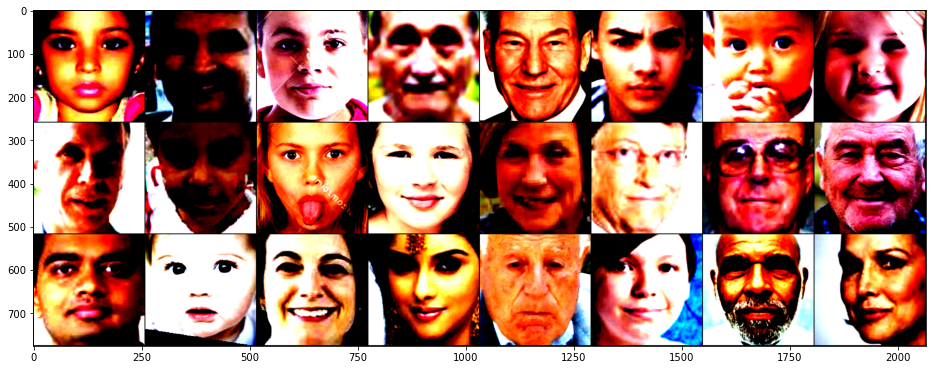

In [15]:
import matplotlib.pyplot as plt
import numpy
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [16]:
def model_eval(dataloader,model):
    total = 0
    correct = 0
    for data in dataloader:
      images, l = data
      
      images = images.to(device)
      l = l.to(device)
      
      out = model(images).float()
      
      
      total += l.shape[0]                   
      correct += (preds == l).sum().item()  
      accuracy = (100 * correct)/total
    
    
    return accuracy

In [17]:


def train(model, criterion, optimizer,sch,num_epochs):
  for epoch in range(num_epochs): 
      print("Epoch:",epoch+1)
      running_loss = 0.0
      
      for i,data in enumerate(train_loader,0):
          inputs,labels = data
          
          
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          optimizer.zero_grad()
    
          output = model(inputs)
          output = output.to(device)
          loss = criterion(output, labels)
    
          loss.backward()
          optimizer.step()
          
          
          running_loss += loss.item()
    
    
          if i % 50 == 49:    
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 50))
              running_loss = 0.0
      sch.step()  
      print('Epoch:', epoch+1,'LR:', sch.get_last_lr())
      print("EPOCH OVER")
      train_acc = model_eval(train_loader,model)
      with torch.no_grad():
        test_acc = model_eval(val_loader,model)
      print("############################")
      print("Training Accuracy:",train_acc,"Testing Accuracy",test_acc)
      print("############################")
      print("")
  return model
    


In [18]:
vgg16_backbone = models.vgg16(pretrained=True)

for param in vgg16_backbone.parameters():
      param.requires_grad = False
#num_ftrs = vgg16_backbone.fc.in_features
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(*list(vgg16_backbone.features.children()))

        self.drop1 = nn.Dropout(0.3)
        #self.drop2 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(32768,1024)
        #self.fc2 = nn.Linear(1024,512)
        self.fc3 = nn.Linear(1024,1)
        self.final = nn.Sigmoid()
    def forward(self,x):
    
        x = self.features(x)

        x = x.view(x.shape[0],32768)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        #x = F.relu(self.fc2(x))
       
        #x = self.drop2(x)
        x = self.fc3(x)
        #x = self.drop1(x)
        #x = F.relu(self.fc4(x))
        x = self.final(x)

        return x       


criterion = nn.CrossEntropyLoss()  
    
vgg_model = VGG16()
vgg_model = vgg_model.to(device)



#optimizer = optim.SGD(vgg_model.parameters(), lr=0.001, momentum=0.9)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.8)
print(vgg_model)



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [19]:
from tqdm import tqdm
def train(loader, model, optimizer, criterion, scaler):
    loop = tqdm(loader) #For the progress bar
    
    for idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.type(torch.float32).unsqueeze(1).to(device)
        targets = 0.01 + targets/100
        #forward pass
        with torch.cuda.amp.autocast():
            pred = model(data)
            loss = criterion(pred, targets)
        #backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        #scheduler.step()
        #lr.append(get_lr(optimizer))
        loop.set_postfix(loss = loss.item())

In [20]:
from tqdm import tqdm
def train1( loader, model, optimizer, criterion, scaler):
        loop = tqdm(loader) #For the progress bar
    
    #for idx, (data, targets) in enumerate(loop):
        data, targets = next(iter(train_loader))
        data = data.to(device)
        targets = targets.float().to(device)
        
        
        #forward pass
        with torch.cuda.amp.autocast():
            pred = model(data)
            loss = criterion(pred, targets)
        #backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loop.set_postfix(loss = loss.item())

In [21]:
d,l = next(iter(train_loader))
d = d.to(device)
l = l.to(device)
x = vgg_model(d).unsqueeze(1)
print(x.shape)
print(l.shape)

torch.Size([32, 1, 1])
torch.Size([32])


In [22]:
optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
#criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()

scaler = torch.cuda.amp.GradScaler()
NUM_EPOCHS = 20
for epoch in range(NUM_EPOCHS):
    print(f"epoch:{epoch}/{NUM_EPOCHS}")
    train(train_loader, vgg_model, optimizer, criterion, scaler)

  0%|          | 0/282 [00:00<?, ?it/s]

epoch:0/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:1/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:2/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:3/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:4/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:5/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:6/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:7/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:8/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:9/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:10/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:11/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:12/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:13/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:14/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:15/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:16/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:17/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:18/20


  0%|          | 0/282 [00:00<?, ?it/s]

epoch:19/20


100%|██████████| 282/282 [01:22<00:00,  3.40it/s, loss=0.000734]


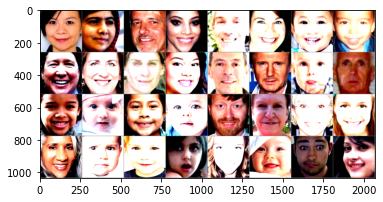

[33, 24, 58, 35, 39, 45, 4, 2, 52, 66, 45, 21, 51, 62, 4, 63, 8, 1, 10, 1, 36, 75, 64, 9, 56, 1, 2, 4, 18, 1, 22, 18]
[20, 19, 54, 25, 58, 55, 0, 3, 48, 60, 53, 25, 52, 65, 10, 66, 3, 0, 16, 0, 41, 68, 58, 7, 43, 0, 2, 10, 30, 0, 25, 28]


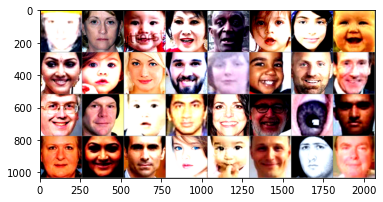

[26, 58, 2, 54, 70, 2, 15, 1, 30, 3, 42, 26, 14, 4, 32, 66, 39, 39, 1, 21, 59, 58, 1, 21, 53, 39, 32, 8, 2, 36, 17, 53]
[33, 51, 5, 46, 54, 2, 23, 1, 41, 0, 62, 35, 36, 11, 31, 50, 43, 36, 3, 31, 64, 55, 40, 24, 46, 22, 34, 17, 0, 37, 40, 46]


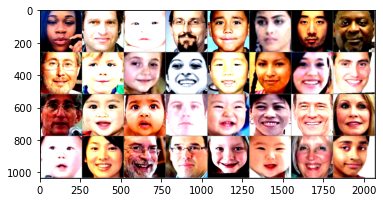

[26, 36, 1, 43, 9, 24, 35, 42, 53, 4, 5, 36, 7, 24, 24, 29, 52, 2, 1, 27, 1, 33, 58, 59, 2, 22, 53, 35, 4, 1, 56, 5]
[26, 45, 0, 54, 8, 28, 23, 45, 51, 1, 5, 43, 12, 29, 30, 40, 67, 1, 0, 47, 2, 31, 60, 26, 3, 16, 53, 49, 10, 0, 59, 11]


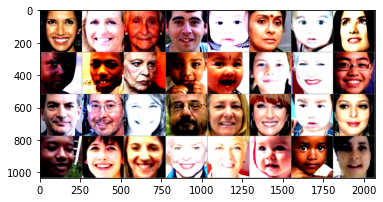

[29, 39, 85, 32, 1, 51, 1, 24, 3, 18, 85, 4, 1, 9, 62, 15, 48, 53, 42, 58, 38, 59, 2, 38, 24, 39, 29, 72, 66, 1, 4, 17]
[37, 40, 81, 28, 0, 43, 0, 23, 12, 29, 78, 4, 3, 39, 70, 24, 44, 49, 31, 57, 29, 64, 1, 40, 34, 29, 21, 59, 65, 0, 7, 18]


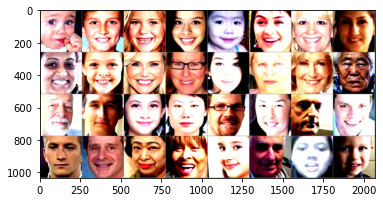

[1, 15, 4, 21, 3, 26, 30, 22, 38, 8, 53, 35, 29, 62, 57, 85, 75, 26, 14, 32, 36, 29, 58, 25, 25, 48, 60, 67, 12, 70, 24, 5]
[4, 15, 33, 19, 2, 28, 53, 23, 36, 6, 57, 43, 22, 57, 70, 90, 68, 32, 20, 28, 37, 34, 62, 41, 30, 47, 63, 40, 12, 72, 17, 2]


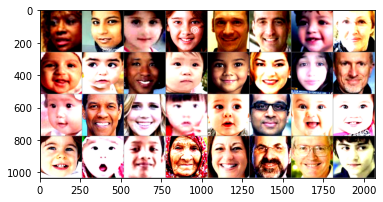

[52, 15, 4, 9, 39, 48, 1, 52, 1, 2, 33, 2, 5, 48, 13, 52, 1, 59, 24, 3, 1, 36, 1, 2, 4, 1, 9, 95, 36, 49, 48, 15]
[33, 14, 6, 5, 47, 51, 14, 52, 2, 2, 40, 1, 6, 26, 11, 49, 4, 38, 28, 0, 0, 31, 0, 0, 1, 0, 29, 85, 38, 55, 51, 8]


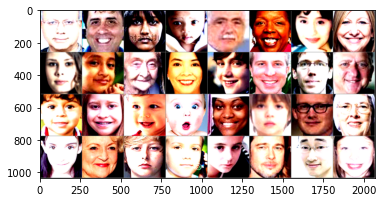

[48, 52, 21, 1, 59, 63, 22, 59, 17, 5, 90, 36, 16, 29, 33, 66, 4, 10, 2, 1, 23, 9, 29, 85, 8, 88, 13, 8, 14, 49, 26, 15]
[49, 46, 46, 2, 54, 52, 19, 48, 26, 33, 67, 26, 17, 38, 41, 56, 1, 5, 0, 0, 27, 19, 39, 77, 21, 86, 6, 15, 7, 28, 39, 23]


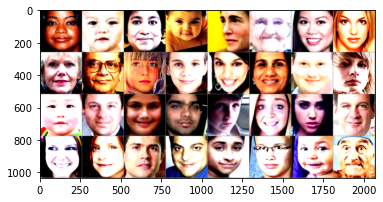

[45, 1, 42, 1, 38, 91, 21, 20, 67, 72, 10, 10, 23, 52, 38, 16, 2, 33, 12, 26, 9, 18, 22, 48, 20, 4, 29, 32, 15, 18, 1, 79]
[40, 0, 40, 7, 31, 70, 13, 19, 71, 59, 45, 14, 19, 44, 48, 15, 0, 32, 11, 33, 15, 14, 38, 51, 24, 18, 28, 49, 20, 23, 0, 82]


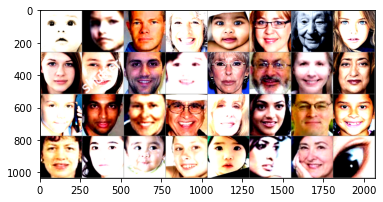

[1, 8, 35, 75, 1, 40, 90, 9, 15, 10, 29, 4, 72, 59, 39, 64, 8, 17, 40, 58, 59, 22, 45, 9, 39, 22, 2, 9, 3, 21, 58, 1]
[0, 18, 35, 62, 0, 44, 88, 15, 15, 11, 36, 7, 75, 43, 30, 54, 6, 29, 61, 60, 55, 29, 55, 5, 34, 26, 0, 10, 2, 12, 36, 7]


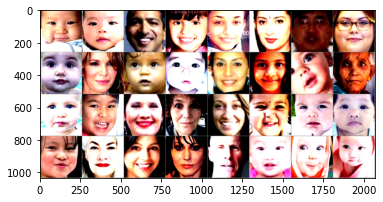

[1, 1, 45, 21, 23, 38, 36, 23, 1, 62, 2, 1, 29, 4, 1, 89, 1, 4, 35, 52, 25, 3, 1, 1, 4, 79, 21, 52, 54, 2, 1, 1]
[0, 0, 38, 4, 20, 44, 30, 25, 0, 46, 0, 0, 29, 14, 16, 69, 0, 3, 47, 47, 23, 2, 0, 2, 12, 68, 26, 43, 51, 0, 4, 0]


In [25]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
i=0
for x,y in val_loader:
    i = i+1
    x=x.cuda()
    y=.01+y.reshape((32,1)).cuda().type(torch.float32)/100
    z=vgg_model(x)

    imshow(torchvision.utils.make_grid(x.cpu()))
    y=(y*100).type(torch.int64)
    z=(z*100).type(torch.int64)
    print(y.reshape(1,32).tolist()[0])
    print(z.reshape(1,32).tolist()[0])
    if(i == 10):
        break
    

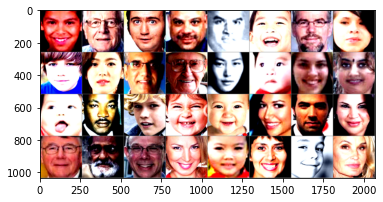

[5, 67, 53, 49, 48, 4, 39, 15, 8, 26, 54, 90, 25, 2, 27, 19, 2, 29, 9, 3, 1, 26, 26, 32, 66, 89, 52, 53, 5, 52, 9, 65]
[6, 70, 53, 46, 51, 1, 42, 17, 6, 27, 55, 93, 22, 1, 26, 11, 0, 24, 14, 4, 0, 22, 20, 28, 66, 87, 52, 67, 3, 55, 10, 68]


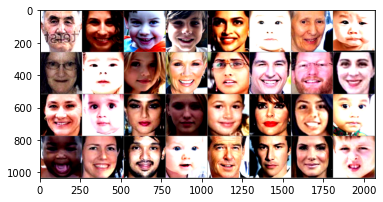

[85, 33, 5, 9, 21, 1, 85, 1, 72, 1, 5, 56, 24, 29, 40, 33, 36, 1, 30, 17, 5, 52, 18, 2, 1, 32, 26, 1, 60, 27, 26, 4]
[87, 36, 1, 6, 22, 0, 81, 0, 76, 0, 4, 56, 23, 33, 41, 34, 39, 0, 34, 17, 9, 58, 18, 1, 1, 33, 24, 0, 59, 30, 23, 1]


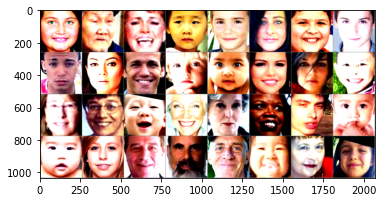

[12, 85, 27, 4, 10, 29, 7, 16, 22, 26, 33, 4, 1, 16, 25, 5, 39, 42, 2, 75, 66, 56, 25, 1, 1, 17, 59, 58, 62, 4, 70, 9]
[6, 84, 25, 3, 11, 32, 7, 18, 28, 31, 36, 5, 0, 19, 27, 5, 45, 45, 0, 71, 68, 57, 23, 0, 0, 22, 58, 55, 60, 2, 73, 10]


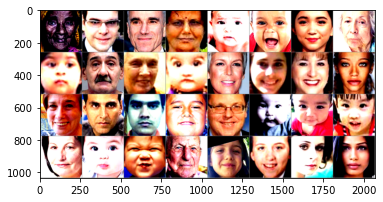

[89, 33, 57, 57, 1, 2, 18, 88, 3, 75, 80, 1, 52, 18, 52, 22, 65, 36, 26, 12, 39, 1, 2, 4, 57, 2, 3, 90, 14, 16, 20, 23]
[92, 30, 57, 62, 0, 1, 18, 91, 2, 76, 78, 0, 57, 21, 49, 21, 71, 36, 24, 16, 40, 0, 2, 3, 54, 1, 1, 87, 11, 16, 28, 28]


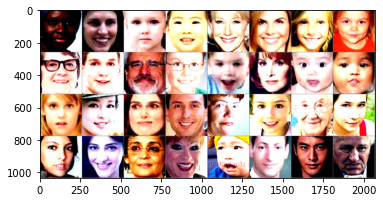

[33, 43, 7, 4, 64, 48, 10, 4, 66, 17, 62, 9, 7, 48, 1, 21, 7, 26, 26, 36, 85, 7, 95, 8, 22, 23, 53, 79, 2, 30, 24, 79]
[32, 50, 2, 4, 59, 45, 10, 4, 55, 14, 60, 6, 6, 47, 0, 0, 7, 12, 29, 38, 86, 6, 95, 5, 18, 25, 49, 79, 4, 33, 28, 77]


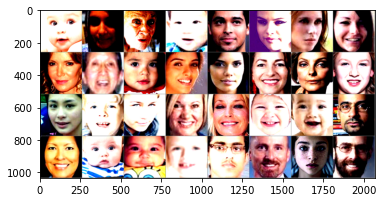

[1, 21, 85, 3, 26, 16, 21, 26, 49, 76, 3, 25, 20, 25, 59, 8, 25, 4, 9, 33, 65, 2, 1, 36, 36, 1, 1, 8, 17, 45, 16, 42]
[0, 19, 87, 0, 27, 12, 16, 22, 57, 75, 0, 21, 15, 25, 62, 11, 23, 5, 8, 33, 61, 2, 1, 36, 36, 0, 1, 0, 17, 45, 23, 41]


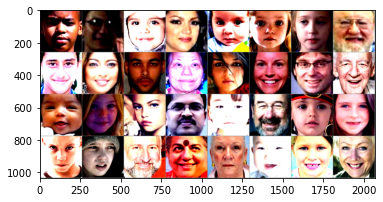

[12, 45, 4, 27, 1, 5, 8, 62, 16, 25, 25, 85, 20, 38, 39, 85, 1, 8, 13, 36, 2, 65, 4, 8, 7, 16, 52, 72, 75, 1, 8, 72]
[13, 48, 6, 25, 0, 2, 10, 60, 14, 24, 26, 88, 15, 33, 37, 82, 1, 8, 17, 39, 1, 62, 2, 6, 6, 16, 56, 73, 70, 1, 7, 74]


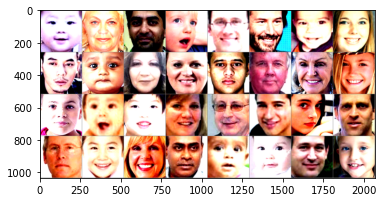

[1, 70, 32, 4, 36, 49, 2, 21, 26, 1, 58, 32, 19, 59, 79, 14, 9, 1, 4, 35, 58, 35, 18, 39, 49, 4, 48, 48, 1, 1, 33, 5]
[0, 67, 32, 1, 33, 53, 0, 22, 25, 1, 60, 34, 19, 65, 78, 10, 6, 2, 4, 36, 61, 32, 17, 39, 46, 9, 49, 49, 2, 0, 34, 3]


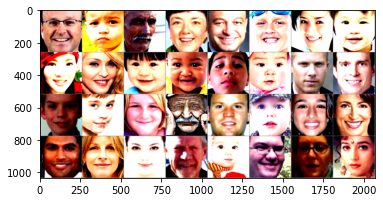

[42, 3, 54, 36, 45, 15, 21, 3, 29, 52, 4, 1, 15, 1, 35, 30, 9, 9, 8, 85, 26, 4, 16, 56, 29, 52, 20, 56, 1, 35, 33, 27]
[39, 0, 65, 31, 40, 4, 24, 0, 28, 48, 5, 2, 15, 0, 34, 34, 11, 6, 6, 84, 23, 1, 15, 50, 31, 53, 17, 45, 0, 35, 40, 22]


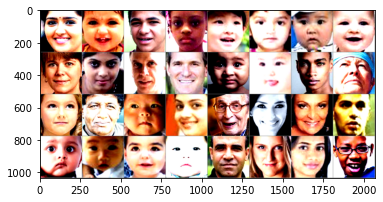

[24, 2, 16, 9, 4, 3, 1, 1, 32, 26, 54, 45, 1, 1, 21, 75, 5, 58, 1, 18, 85, 29, 46, 22, 1, 1, 2, 1, 46, 25, 24, 9]
[26, 0, 18, 8, 2, 0, 2, 0, 32, 23, 55, 42, 2, 2, 20, 73, 2, 64, 0, 15, 86, 35, 51, 21, 0, 0, 1, 0, 46, 26, 22, 5]


In [27]:
i=0
for x,y in train_loader:
    i = i+1
    x=x.cuda()
    y=.01+y.reshape((32,1)).cuda().type(torch.float32)/100
    z=vgg_model(x)

    imshow(torchvision.utils.make_grid(x.cpu()))
    y=(y*100).type(torch.int64)
    z=(z*100).type(torch.int64)
    print(y.reshape(1,32).tolist()[0])
    print(z.reshape(1,32).tolist()[0])
    if(i == 10):
        break